# SANKALP KUMAR | CS24MTECH11026

# 1.

In [3]:
import os
import requests
import zipfile
import io
import re
import collections
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm

In [4]:
# Check if GPU is available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'USING DEVICE | {str(device).upper()}')

USING DEVICE | CUDA


# 1. (a)

### Downloading & extracting the **[text8](http://mattmahoney.net/dc/text8.zip)** corpus

In [5]:
if not os.path.exists('text8.zip'):
    url = 'http://mattmahoney.net/dc/text8.zip'
    r = requests.get(url)
    with open('text8.zip', 'wb') as f:
        f.write(r.content)

# Extract the dataset from the downloaded zip file
with zipfile.ZipFile('text8.zip') as z:
    text = z.read(z.namelist()[0]).decode('utf-8')
# with zipfile.ZipFile('text8.zip') as z:
#     text = z.read(z.namelist()[0]).decode('utf-8')  # Read and decode the text

### Preprocessing the **[text8](http://mattmahoney.net/dc/text8.zip)** corpus

In [6]:
# Preprocessing step:
# - Convert the entire text to lowercase
# - Remove all non-alphabetic characters (punctuation, numbers, etc.)
# - Tokenize the text by splitting on spaces
text = text.lower()
text = re.sub(r'[^a-z]+', ' ', text).split()

# Build the vocabulary:
# - Take the top 75,000 most frequent words in the dataset
# - Assign each word a unique integer index starting from 1
# - Reserve index 0 for <UNK> token (to handle rare or unknown words)
vocab_size = 100000
counter = collections.Counter(text).most_common(vocab_size - 1)
vocab = {word: idx + 1 for idx, (word, _) in enumerate(counter)}
vocab['<UNK>'] = 0  # index 0 will be used for unknown words

# Encode the entire text into a list of word indices:
# - Every word is replaced by its corresponding index from the vocab
# - Words not in the top 75k will be mapped to <UNK> (index 0)
data = [vocab.get(word, 0) for word in text]


In [7]:
len(vocab)

100000

# 1. (b)

### NegativeSampler

In [8]:
# Faster NegativeSampler using torch.bincount()
class NegativeSampler:
    def __init__(self, corpus, vocab_size, power=0.75, device='cpu'):
        self.device = device

        # Count word frequencies efficiently using torch.bincount
        word_counts = torch.bincount(torch.tensor(corpus), minlength=vocab_size).float()

        # Apply smoothing to the distribution (word2vec-style)
        self.prob = (word_counts ** power)

        # Normalize to get a proper probability distribution
        self.prob = self.prob / self.prob.sum()

        # Move to the specified device (GPU recommended)
        self.prob = self.prob.to(self.device)

    def sample(self, batch_size, n_negatives):
        # Sample negative words efficiently using multinomial sampling
        return torch.multinomial(self.prob, batch_size * n_negatives, replacement=True).view(batch_size, n_negatives)

# Create sampler instance
sampler = NegativeSampler(data, vocab_size, device=device)


### Skip-gram model with **negative sampling loss**

In [9]:
# Skip-gram model with negative sampling loss
class SkipGramNS(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()

        # Input embedding matrix for center words
        self.input_embeddings = nn.Parameter(torch.randn(vocab_size, embedding_dim) * 0.01)

        # Output embedding matrix for context and negative words
        self.output_embeddings = nn.Parameter(torch.randn(vocab_size, embedding_dim) * 0.01)

    def forward(self, center_word, context_word, negative_words):
        # Look up embeddings for center and context words
        center_embed = self.input_embeddings[center_word]
        context_embed = self.output_embeddings[context_word]

        # Positive pair loss: center word and true context word
        pos_score = torch.sum(center_embed * context_embed, dim=1)
        pos_loss = torch.log(torch.sigmoid(pos_score) + 1e-10)
#
        # Negative pair loss: center word and negative samples
        neg_embed = self.output_embeddings[negative_words]
        neg_score = torch.bmm(neg_embed, center_embed.unsqueeze(2)).squeeze()
        neg_loss = torch.sum(torch.log(torch.sigmoid(-neg_score) + 1e-10), dim=1)

        # Total loss = negative of (positive + negative log-likelihood)
        loss = - (pos_loss + neg_loss)
        return loss.mean()


# 1. (c)

### Generateing batch of (center, context) word pairs wrt window_size

In [11]:
# Generates a batch of (center, context) word pairs for skip-gram training
def generate_batch(data, batch_size, window_size):
    batch = []
    for _ in range(batch_size):
        # Randomly select a center word position (avoid borders)
        center = random.randint(window_size, len(data) - window_size - 1)

        # Randomly pick a context word within the window, excluding the center itself
        context = random.choice([i for i in range(center - window_size, center + window_size + 1) if i != center])

        # Store the pair (center word id, context word id)
        batch.append((data[center], data[context]))

    # Returns two lists: centers and contexts
    return zip(*batch)


>### Model and training hyperparameters


In [14]:
# Model and training hyperparameters
embedding_dim = 300       # Dimension of word embeddings
window_size = 5           # Context window size (how many words to left/right)
neg_samples = 15          # Number of negative samples per positive pair
batch_size = 1024         # Number of samples in each training batch
epochs = 5                # Number of passes over the data (not strict in our case)
total_steps = 200000      # Total number of training steps (batches)

# Initialize skip-gram model and move it to the device
skipgram_model = SkipGramNS(vocab_size, embedding_dim).to(device)

# Adam optimizer for training
skipgram_optimizer = optim.Adam(skipgram_model.parameters(), lr=0.003)
# Optimizer: Adam is a good choice for word embeddings as it handles
# sparse gradients well and adapts learning rates per parameter
# optimizer = optim.Adam([input_embeddings, output_embeddings], lr=0.003)


### Training/Loading model (if available)

In [19]:
# Calculate number of steps per epoch
steps_per_epoch = total_steps // epochs

# Training loop with progress bar
for epoch in range(epochs):
    total_loss = 0
    # tqdm progress bar with step count, epoch info, and dynamic loss
    with tqdm(range(steps_per_epoch), desc=f'Epoch [{epoch+1}/{epochs}]') as pbar:
        for step in pbar:
            # Generate a random batch of (center, context) pairs
            center, context = generate_batch(data, batch_size, window_size)
            center = torch.tensor(center, dtype=torch.long).to(device)
            context = torch.tensor(context, dtype=torch.long).to(device)

            # Sample negatives
            negatives = sampler.sample(batch_size, neg_samples)

            # Forward pass and optimization
            skipgram_optimizer.zero_grad()
            loss = skipgram_model(center, context, negatives)
            loss.backward()
            skipgram_optimizer.step()

            total_loss += loss.item()

            # Display smoothed loss in tqdm
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    print(f"Epoch [{epoch+1}/{epochs}] completed | Average Loss: {total_loss / steps_per_epoch:.4f}")

print("Training Finished.")


Epoch [1/5]: 100%|██████████| 40000/40000 [18:38<00:00, 35.75it/s, loss=3.2539]


Epoch [1/5] completed | Average Loss: 3.3904


Epoch [2/5]: 100%|██████████| 40000/40000 [18:38<00:00, 35.76it/s, loss=3.3281]


Epoch [2/5] completed | Average Loss: 3.3396


Epoch [3/5]: 100%|██████████| 40000/40000 [18:36<00:00, 35.82it/s, loss=3.3225]


Epoch [3/5] completed | Average Loss: 3.3345


Epoch [4/5]: 100%|██████████| 40000/40000 [18:33<00:00, 35.91it/s, loss=3.2904]


Epoch [4/5] completed | Average Loss: 3.3404


Epoch [5/5]: 100%|██████████| 40000/40000 [18:33<00:00, 35.91it/s, loss=3.3482]

Epoch [5/5] completed | Average Loss: 3.3477
Training Finished.


---

# 1. (d)

- ### Visualization using SVD

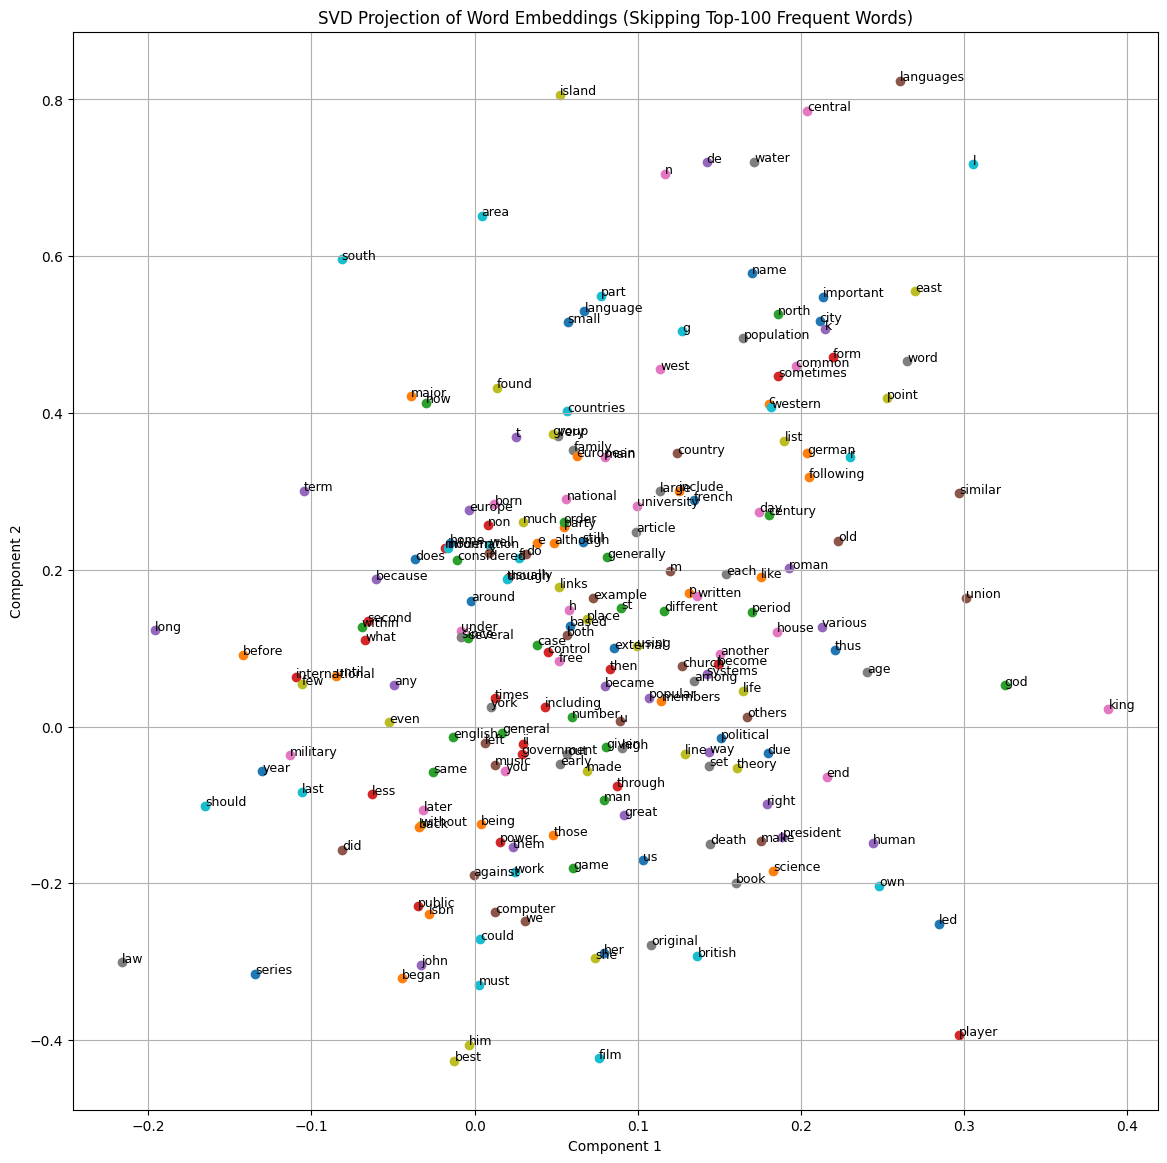

In [34]:
# Visualize embeddings highlighting meaningful (non-stop) words

from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Detach embeddings
word_embeddings = skipgram_model.input_embeddings.detach().cpu().numpy()

# Apply SVD to reduce to 2D
svd = TruncatedSVD(n_components=2)
reduced = svd.fit_transform(word_embeddings)

# Prepare meaningful words (skip the most frequent)
# Skip top 100 words to remove common stopwords
selected_words = list(vocab.items())[100:300]  # words ranked 100 to 300 by frequency

plt.figure(figsize=(14, 14))

# Plot selected words
for word, idx in selected_words:
    plt.scatter(reduced[idx, 0], reduced[idx, 1])
    plt.text(reduced[idx, 0], reduced[idx, 1], word, fontsize=9)

plt.title("SVD Projection of Word Embeddings (Skipping Top-100 Frequent Words)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()



- ### Word Similarity

In [42]:
# Performs word analogy task: a - b + c ≈ ?
def analogy(a, b, c, top_k=5):
    # Compute the analogy vector: vec = embedding(a) - embedding(b) + embedding(c)
    vec = skipgram_model.input_embeddings[vocab[a]] - skipgram_model.input_embeddings[vocab[b]] + skipgram_model.input_embeddings[vocab[c]]
    vec = vec / (vec.norm() + 1e-9)  # Normalize to unit vector

    # Compute cosine similarities between vec and all word embeddings
    sims = torch.matmul(skipgram_model.input_embeddings, vec) / (torch.norm(skipgram_model.input_embeddings, dim=1) + 1e-9)

    # Exclude the words a, b, c from the candidates to prevent trivial matches
    excluded_indices = set([vocab[a], vocab[b], vocab[c]])
    for idx in excluded_indices:
        sims[idx] = -float('inf')  # Assign -inf similarity to ignore them

    # Retrieve the top_k most similar words
    values, indices = torch.topk(sims, top_k)

    # Return formatted analogy result
    return f'{a} - {b} + {c} ≈ {[list(vocab.keys())[list(vocab.values()).index(i.item())] for i in indices]}'


print(analogy('queen', 'woman', 'man'))
print(analogy('actor', 'man', 'woman'))
print(analogy('son', 'man', 'woman'))  

queen - woman + man ≈ ['royal', 'king', 'lord', 'arag', 'consort']
actor - man + woman ≈ ['actress', 'singer', 'politician', 'nine', 'writer']
son - man + woman ≈ ['daughter', 'wife', 'her', 'married', 'mother']


In [33]:
print(analogy('queen', 'woman', 'man'))
print(analogy('actor', 'man', 'woman'))
print(analogy('man', 'male', 'female'))  
print(analogy('ego', 'male', 'female'))
print(analogy('king', 'man', 'woman')) 

# elon - tesla + jeff : ?

queen - woman + man ≈ ['royal', 'king', 'lord', 'arag', 'consort']
actor - man + woman ≈ ['actress', 'singer', 'politician', 'nine', 'writer']
man - male + female ≈ ['album', 'woman', 'soldier', 'nothing', 'paul']
ego - male + female ≈ ['mihi', 'turgenev', 'unpredictability', 'ultramagnetic', 'character']
king - man + woman ≈ ['daughter', 'montferrat', 'bessus', 'theuderic', 'queen']


In [ ]:
def get_nearest_neighbors(word, top_k=5):
    if word not in vocab:
        return []
    idx = vocab[word]
    embedding = skipgram_model.input_embeddings[idx].detach()
    sims = torch.matmul(skipgram_model.input_embeddings, embedding) / (torch.norm(skipgram_model.input_embeddings, dim=1) * torch.norm(embedding) + 1e-9)
    values, indices = torch.topk(sims, top_k + 1)
    return print(f'Nearest neighbors of {word} | {[list(vocab.keys())[list(vocab.values()).index(i.item())] for i in indices[1:]]}')

get_nearest_neighbors('king')

Nearest neighbors of king | ['son', 'emperor', 'ii', 'charles', 'crowned']


# 1. (e)



### Embedding Dimension

This is basically about how much information each word vector can hold. It can thought as the size of the space where words are represented.

- If we pick a **small dimension** (eg below 100), the model might not have enough room to capture meaningful patterns between words, leading to poor-quality embeddings.
- On the other hand, if we go **too high** (eg above 500), we may run into overfitting and unnecessary computational load without much actual benefit.
- For **text8** dataset, values between **100 and 300** generally work well.

---

### Context Window Size

This tells the model how many neighboring words (left and right) to consider when learning word relationships.

- A **small window** (eg around 2 to 5) helps the model focus on **syntactic** patterns — things like grammar, function words, and word order.
- A **larger window** (eg 6 or more) tends to capture **semantic** information — broader topics and associations beyond immediate neighbors.
- For text8, a **window size of 5** is a good trade-off and works well for balancing both syntax and semantics.

---

### Number of Negative Samples

Negative sampling tells the model that "these random words are definitely *not* the right context". The model learns by contrasting correct vs. incorrect contexts.

- If we use **too few negative samples** (2 to 5), the model may not learn to distinguish contexts properly.
- If we use **too many** (more than 20), it becomes computationally expensive without much improvement.
- For text8 we stick to 15 negative samples.
---
### Hyperparameters effects on skipgram model trained on text8

| Hyperparameter | What it Controls | Too Small | Too Large | Typical Range |
|----------------|-----------------|-----------|-----------|---------------|
| Embedding Dimension | Capacity to store word meaning | Poor embeddings | Overfitting & slow | 100 - 300 |
| Context Window | How much context is seen | Only local grammar | May dilute meaning | 5 - 8 |
| Negative Samples | Strength of contrast learning | Weak signals | Wastes compute | 5 - 20 |

---

### Used hyperparameters for text8 

| Parameter | Recommended Value |
|-----------|------------------|
| Embedding Dimension | 200 - 300 |
| Context Window Size | 5 |
| Negative Samples | 10 - 15 |

```
When we increase:
- Embedding Dimension: We give the model more space to capture word meanings.
- Context Window: The model sees a wider context, focusing more on semantics.
- Negative Samples: The model becomes better at telling real contexts from random noise.
```

# 2.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import random
import math
from tqdm import tqdm
import numpy as np

In [2]:
plt.style.use('seaborn-v0_8-paper')
# Check if GPU is available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'USING DEVICE | {str(device).upper()}')

USING DEVICE | CPU


# 2. (a)

In [45]:
# Converts the input image into a sequence of patch embeddings
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=256):
        super().__init__()
        # Total number of patches the image will be split into
        self.num_patches = (img_size // patch_size) ** 2

        # A Conv2D acts as both patch extraction and linear projection:
        # It divides the image into non-overlapping patches and embeds them into a higher dimensional space
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Input: x shape = [Batch, Channels, Height, Width]
        x = self.proj(x)                        # Output: [Batch, embed_dim, H/patch, W/patch]
        x = x.flatten(2).transpose(1, 2)        # Reshape to [Batch, Num_patches, embed_dim]
        return x

In [46]:
# Standard Multi-Head Self-Attention mechanism used in Vision Transformers
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads  # Each head will work on a smaller embedding
        self.scale = self.head_dim ** -0.5      # Scaling factor to stabilize dot-product attention

        # A single linear layer computes Q, K, V simultaneously for efficiency
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)

        # Final linear layer to merge the heads
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape  # Batch, Number of tokens, Embedding dimension

        # Project and reshape into multi-head Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # q, k, v shapes: [Batch, Heads, Tokens, Head_dim]

        # Compute raw attention scores (scaled dot-product)
        attn_scores = (q @ k.transpose(-2, -1)) * self.scale  # [B, Heads, Tokens, Tokens]

        # Convert scores to probabilities using softmax
        attn = attn_scores.softmax(dim=-1)

        # Compute weighted sum of values using attention weights
        attn_out = (attn @ v).transpose(1, 2).reshape(B, N, C)

        # Final projection to mix head outputs
        return self.out_proj(attn_out), attn


In [72]:
# The basic building block of the Vision Transformer
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, mlp_ratio=4.0, drop_rate=0.1):
        super().__init__()

        # Layer Normalization before attention
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)

        # Layer Normalization before the MLP block
        self.norm2 = nn.LayerNorm(embed_dim)

        # MLP block (position-wise feedforward)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),  # Increase dimension (expansion)
            nn.GELU(),                                         # Non-linearity
            nn.Dropout(drop_rate),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),   # Project back to original embed_dim
            nn.Dropout(drop_rate)
        )

    def forward(self, x):
        # Apply self-attention (with skip connection)
        attn_out, attn = self.attn(self.norm1(x))
        x = x + attn_out

        # Apply MLP block (with skip connection)
        x = x + self.mlp(self.norm2(x))

        return x, attn

In [48]:
# The complete Vision Transformer model (Encoder only, no decoder)
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=256, depth=6, num_heads=8, mlp_ratio=4.0):
        super().__init__()

        # Converts the image into a sequence of patch embeddings
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        # Learnable [CLS] token added in front of the patch sequence
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Learnable positional embeddings for patches + [CLS] token
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)  # Recommended initialization

        # A stack of transformer encoder blocks
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio) for _ in range(depth)
        ])

        # Final LayerNorm
        self.norm = nn.LayerNorm(embed_dim)

        # Classification head (linear layer projecting CLS token to class scores)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]  # Batch size

        # Convert image into patch embeddings
        x = self.patch_embed(x)  # Shape: [B, num_patches, embed_dim]

        # Duplicate [CLS] token for each sample in the batch
        cls_tokens = self.cls_token.expand(B, -1, -1)  # Shape: [B, 1, embed_dim]

        # Prepend the [CLS] token to the patch sequence
        x = torch.cat((cls_tokens, x), dim=1)  # Shape: [B, num_patches+1, embed_dim]

        # Add positional embeddings
        x = x + self.pos_embed

        # Pass through all transformer blocks
        attn_maps = []  # store attention maps for visualization
        for block in self.blocks:
            x, attn = block(x)
            attn_maps.append(attn)

        # Normalize the final hidden state
        x = self.norm(x)

        # Extract the [CLS] token's representation
        cls_output = x[:, 0]  # Only the CLS token is used for classification

        # Return the class logits and attention maps
        return self.head(cls_output), attn_maps


# 2. (b)

In [49]:
# Data augmentation for training set
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),      # randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),   # randomly crop with padding to preserve size
    transforms.ToTensor(),                  # convert images to PyTorch tensor
])

# Load CIFAR-10 training dataset with augmentation
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

# Load CIFAR-10 test dataset without augmentation
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transforms.ToTensor()
)

# Create data loaders to load batches efficiently
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)   # shuffle = True for better training
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)    # shuffle = False for consistent evaluation

100%|██████████| 170M/170M [00:01<00:00, 106MB/s]  


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [50]:
# Create Vision Transformer model and move it to the selected device
model_vit = VisionTransformer().to(device)

# Define loss function (Cross Entropy is standard for classification)
criterion = nn.CrossEntropyLoss()

# AdamW optimizer (Adam + weight decay, works better for transformers)
optimizer_vit = optim.AdamW(model_vit.parameters(), lr=3e-4, weight_decay=0.05)

In [51]:
from tqdm import tqdm

num_epochs_vit = 50

for epoch in range(num_epochs_vit):
    model_vit.train()
    total_loss = 0
    correct = 0

    # tqdm progress bar for batches inside the epoch
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs_vit}]", leave=False)

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)   # move batch to GPU (or CPU if needed)

        optimizer_vit.zero_grad()                               # reset gradients
        outputs, _ = model_vit(imgs)                            # forward pass
        loss = criterion(outputs, labels)                   # compute loss
        loss.backward()                                     # backpropagation
        optimizer_vit.step()                                    # update parameters

        total_loss += loss.item() * imgs.size(0)            # accumulate total loss
        correct += (outputs.argmax(1) == labels).sum().item()  # accumulate correct predictions

        # live progress bar update showing current batch loss and accuracy
        loop.set_postfix({
            'Batch Loss': f"{loss.item():.4f}",
            'Train Acc': f"{100 * correct / ((loop.n + 1) * train_loader.batch_size):.2f}%"
        })

    avg_loss = total_loss / len(train_loader.dataset)       # average loss over entire dataset
    epoch_acc = correct / len(train_loader.dataset)         # final epoch accuracy

    print(f"Epoch [{epoch+1}/{num_epochs_vit}] | Train Loss: {avg_loss:.4f} | Train Acc: {epoch_acc*100:.2f}%")


Epoch [1/50] | Train Loss: 1.9149 | Train Acc: 27.73%


Epoch [2/50] | Train Loss: 1.5021 | Train Acc: 45.13%


Epoch [3/50] | Train Loss: 1.3678 | Train Acc: 50.21%


Epoch [4/50] | Train Loss: 1.2961 | Train Acc: 52.87%


Epoch [5/50] | Train Loss: 1.2539 | Train Acc: 54.69%


Epoch [6/50] | Train Loss: 1.2054 | Train Acc: 56.43%


Epoch [7/50] | Train Loss: 1.1750 | Train Acc: 57.56%


Epoch [8/50] | Train Loss: 1.1529 | Train Acc: 58.08%


Epoch [9/50] | Train Loss: 1.1232 | Train Acc: 59.45%


Epoch [10/50] | Train Loss: 1.0961 | Train Acc: 60.43%


Epoch [11/50] | Train Loss: 1.0859 | Train Acc: 60.77%


Epoch [12/50] | Train Loss: 1.0662 | Train Acc: 61.53%


Epoch [13/50] | Train Loss: 1.0448 | Train Acc: 62.55%


Epoch [14/50] | Train Loss: 1.0261 | Train Acc: 63.09%


Epoch [15/50] | Train Loss: 1.0200 | Train Acc: 63.31%


Epoch [16/50] | Train Loss: 0.9959 | Train Acc: 64.31%


Epoch [17/50] | Train Loss: 0.9831 | Train Acc: 64.50%


Epoch [18/50] | Train Loss: 0.9699 | Train Acc: 65.11%


Epoch [19/50] | Train Loss: 0.9580 | Train Acc: 65.58%


Epoch [20/50] | Train Loss: 0.9386 | Train Acc: 66.20%


Epoch [21/50] | Train Loss: 0.9201 | Train Acc: 66.99%


Epoch [22/50] | Train Loss: 0.9102 | Train Acc: 67.21%


Epoch [23/50] | Train Loss: 0.8990 | Train Acc: 67.51%


Epoch [24/50] | Train Loss: 0.8865 | Train Acc: 68.21%


Epoch [25/50] | Train Loss: 0.8743 | Train Acc: 68.46%


Epoch [26/50] | Train Loss: 0.8580 | Train Acc: 69.11%


Epoch [27/50] | Train Loss: 0.8511 | Train Acc: 69.30%


Epoch [28/50] | Train Loss: 0.8389 | Train Acc: 69.91%


Epoch [29/50] | Train Loss: 0.8236 | Train Acc: 70.54%


Epoch [30/50] | Train Loss: 0.8039 | Train Acc: 71.10%


Epoch [31/50] | Train Loss: 0.7945 | Train Acc: 71.27%


Epoch [32/50] | Train Loss: 0.7828 | Train Acc: 71.66%


Epoch [33/50] | Train Loss: 0.7657 | Train Acc: 72.53%


Epoch [34/50] | Train Loss: 0.7571 | Train Acc: 72.67%


Epoch [35/50] | Train Loss: 0.7474 | Train Acc: 72.86%


Epoch [36/50] | Train Loss: 0.7294 | Train Acc: 73.61%


Epoch [37/50] | Train Loss: 0.7183 | Train Acc: 74.05%


Epoch [38/50] | Train Loss: 0.7046 | Train Acc: 74.55%


Epoch [39/50] | Train Loss: 0.6877 | Train Acc: 75.13%


Epoch [40/50] | Train Loss: 0.6732 | Train Acc: 75.63%


Epoch [41/50] | Train Loss: 0.6608 | Train Acc: 76.04%


Epoch [42/50] | Train Loss: 0.6408 | Train Acc: 76.79%


Epoch [43/50] | Train Loss: 0.6426 | Train Acc: 76.79%


Epoch [44/50] | Train Loss: 0.6237 | Train Acc: 77.39%


Epoch [45/50] | Train Loss: 0.6073 | Train Acc: 78.18%


Epoch [46/50] | Train Loss: 0.5921 | Train Acc: 78.62%


Epoch [47/50] | Train Loss: 0.5800 | Train Acc: 79.22%


Epoch [48/50] | Train Loss: 0.5667 | Train Acc: 79.49%


Epoch [49/50] | Train Loss: 0.5560 | Train Acc: 79.86%


Epoch [50/50] | Train Loss: 0.5397 | Train Acc: 80.25%


# 2. (c)

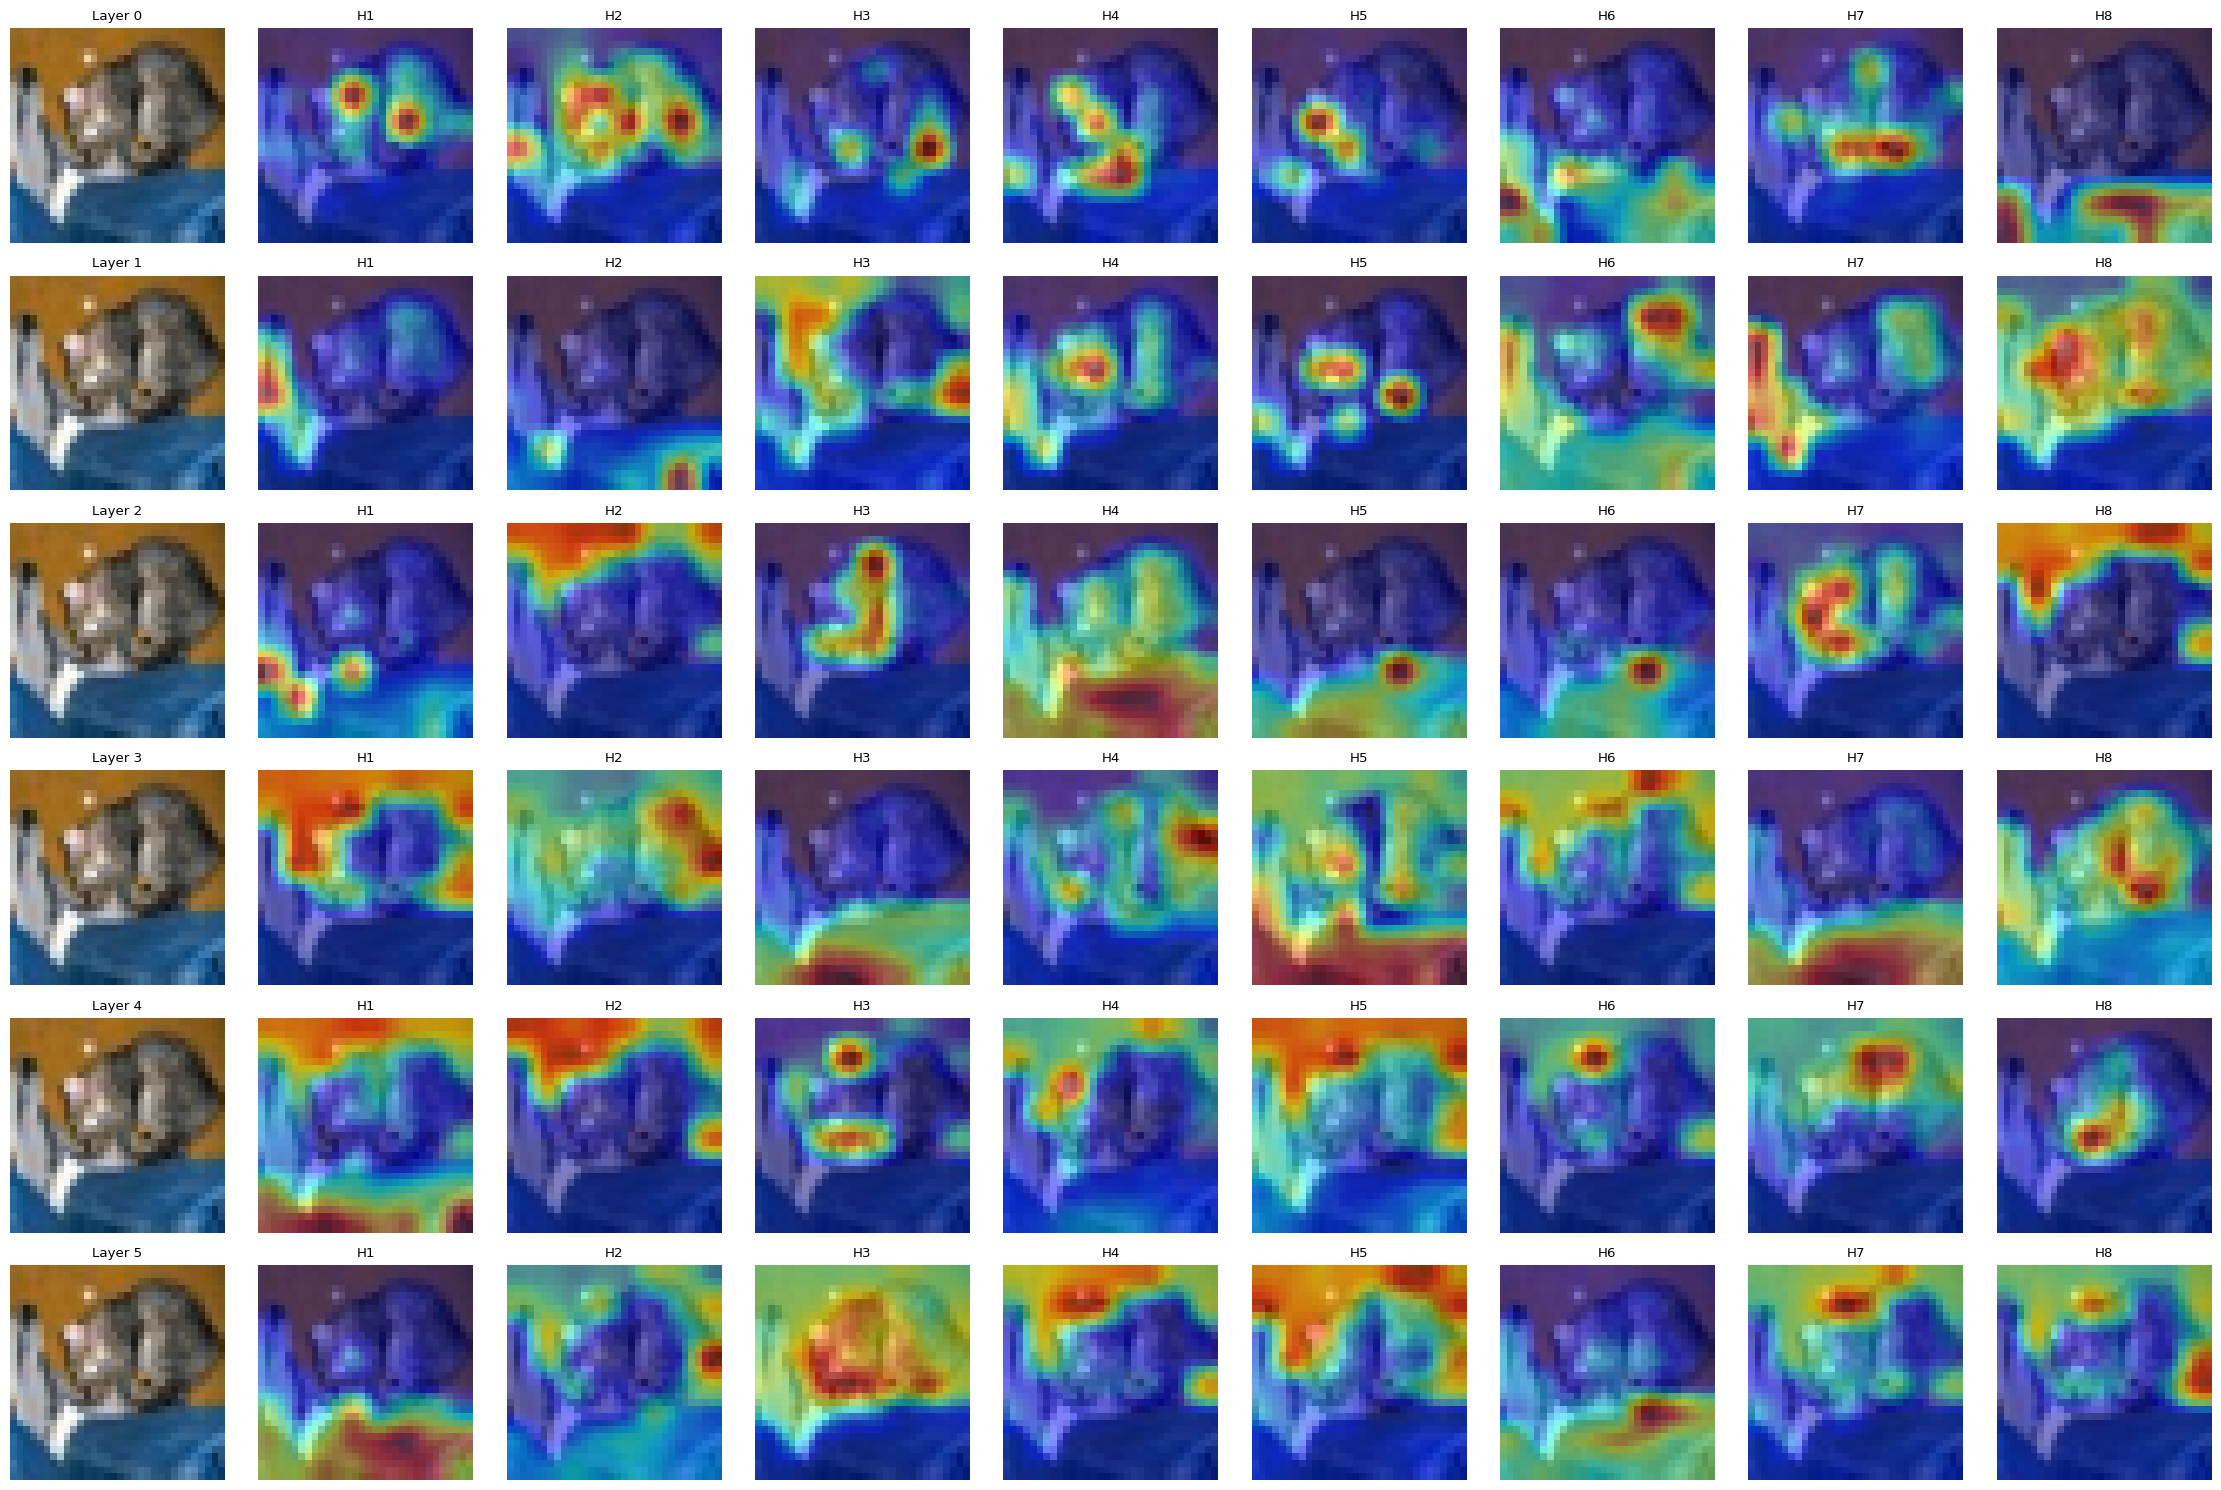

In [64]:
def plot_layer_head_matrix_sharp_v2(model, img_tensor, layers_to_plot=[0, 2, 5], upscale=32, sharpen_factor=0.7, save_path=None):
    """
    Plots attention maps as a Layer × Head matrix.
    Each row = a selected transformer layer
    Each column = a different attention head
    """

    model.eval()  # Set model to evaluation mode

    num_heads = model.blocks[0].attn.num_heads  # Get number of attention heads from the model

    # Create a grid of subplots: rows = layers, columns = heads + original image
    fig, axs = plt.subplots(
        len(layers_to_plot), num_heads + 1,  # +1 for showing the input image in each row
        figsize=(2.5 * (num_heads + 1), 2.5 * len(layers_to_plot))  # Control figure size
    )

    axs = np.atleast_2d(axs)  # Ensure axs is always 2D even if there's only one layer

    # Normalize the input image and convert to PIL image for plotting
    img = img_tensor.cpu()
    img = img - img.min()  # Shift min to 0
    img = img / img.max()  # Normalize to [0,1]
    img = TF.to_pil_image(img)

    # Add batch dimension and move the image to the model's device
    input_img = img_tensor.unsqueeze(0).to(next(model.parameters()).device)

    # Get attention maps from the model (already pre-modified model returns attn_maps)
    with torch.no_grad():
        _, attn_maps = model(input_img)   # attn_maps is a list: [layer][batch][head, token, token]

    # For each selected layer
    for row, layer in enumerate(layers_to_plot):
        attn = attn_maps[layer][0]   # [num_heads, tokens, tokens] -> Take the first sample in batch

        cls_attn = attn[:, 0, 1:]    # Attention from CLS token to all patches -> [num_heads, num_patches]
        grid_size = int(math.sqrt(cls_attn.shape[1]))  # Recover grid shape (assumes square grid)

        axs[row, 0].imshow(img)  # First column shows the original input image
        axs[row, 0].set_title(f"Layer {layer}")  # Title = layer number
        axs[row, 0].axis('off')  # Hide axes

        # For each head in this layer
        for h in range(num_heads):
            # Reshape flat attention vector to a grid [grid_size x grid_size]
            patch_attn = cls_attn[h].reshape(grid_size, grid_size).unsqueeze(0).unsqueeze(0)

            # Upscale attention map to match image resolution for better visualization
            patch_attn = F.interpolate(patch_attn, size=(upscale, upscale), mode='bilinear', align_corners=False)

            # Optional sharpening of the attention map
            sharpened_attn = patch_attn[0, 0].cpu().numpy()  # Remove batch & channel dims
            sharpened_attn = sharpened_attn ** sharpen_factor  # Sharpen using power
            sharpened_attn = sharpened_attn / sharpened_attn.max()  # Normalize to [0,1]

            # Overlay sharpened attention map on the original image
            axs[row, h + 1].imshow(img)
            axs[row, h + 1].imshow(sharpened_attn, cmap='jet', alpha=0.5)  # Heatmap overlay
            axs[row, h + 1].set_title(f'H{h+1}')  # Title = Head number
            axs[row, h + 1].axis('off')  # Hide axes

    # Layout adjustment
    plt.tight_layout()

    # Save if path is provided
    if save_path is not None:
        plt.savefig(save_path)
        print(f"Saved to {save_path}")

    plt.show()  # Display the figure


img_tensor, label = test_set[0]

plot_layer_head_matrix_sharp_v2(
    model=model_vit,
    img_tensor=img_tensor,
    layers_to_plot=[0, 1, 2, 3, 4, 5],
    sharpen_factor=0.7,
    save_path="attention_matrix.png"   # optional
)



## **Attention Map Analysis: Layer-wise & Head-wise**

---

### **Layer-wise Progression (Global Context Building)**

| Layer | Global Behavior |
|-------|----------------|
| **Layer 0** | All heads perform **local texture-level attention**. Focus is patchy and spread. Mostly edges, textures, gradients, and sharp color transitions are attended. No clear object boundary. |
| **Layer 1** | Heads begin to **aggregate local patterns** into larger regions. Attention is less noisy, and some heads start looking at broader regions like portions of the cat's head or body. |
| **Layer 2** | Several heads (`H2`, `H5`, `H8`) show a clear focus on the **object’s main regions** (cat's head and body). Model starts recognizing **object parts** beyond textures. |
| **Layer 3** | **Global spatial relationships** start emerging. Heads begin ignoring the background more consistently and cluster attention on **semantically important parts** like the face, body, and contour of the cat. |
| **Layer 4** | Attention is now highly **structured**. Many heads become confident and specific. For example, some heads focus directly on the **cat’s head**, while others highlight the **cat’s back** or the **foreground** regions. |
| **Layer 5** | The model demonstrates strong **object-level attention**. Several heads precisely focus on the **cat’s complete shape** or specific **salient parts** (ears, eyes, face). Background distraction is minimized. |

---

### **Head-wise Specialization (Within each layer)**

| Head | Observed Role (Cross-layers) |
|------|-----------------------------|
| **H1** | Frequently detects **borders and contours**, often focusing on boundaries and edges both in early and deep layers. |
| **H2** | Shows a tendency to attend to **textured regions** or **regions with high color variance** (possibly fur texture). Starts contributing to global attention in Layer 3+. |
| **H3** | Acts as a **fine-detail head**, usually localizing on **specific sub-parts** such as the **ears**, **eyes**, or a small patch of the cat's face. Its sharp focus becomes prominent from Layer 3 onwards. |
| **H4** | Focuses on **middle-sized structures**, e.g., sections of the **face**, **body**, or **transition regions** between object and background. |
| **H5** | Consistently acts as a **body-region head**. In most layers, H5 allocates attention to the **lower-half** or **center** of the object. |
| **H6** | Starts off diffuse but later contributes to **foreground-background separation**, often modeling the **whole object shape** in Layer 4+. |
| **H7** | Shows specialization towards **completing missing parts** (fills gaps in attention left by other heads). It plays a stabilizing role in Layers 3 to 5. |
| **H8** | Alternates between **context head** (attending the background) and **refinement head** (focusing on small object areas). By Layer 5, H8 aligns more with object localization. |

---

### **Combined Insight**

- The model is **progressively organizing spatial relationships** layer by layer.
- The **heads cooperate** by specializing:
   - Some heads focus on **global shapes**.
   - Some focus on **fine details**.
   - Some help in **ignoring irrelevant background**.
- This diverse behavior is a hallmark of **multi-head attention** in ViTs.
- In deeper layers, the model is learning **hierarchical representation**:  
   Texture → Object Parts → Full Object → Context Refinement.

---

> "As we move from Layer 0 to Layer 5, the model transitions from patch-level attention to object-level attention. Each head contributes differently — some heads specialize in fine details like eyes and ears, some in larger structures like the body, and some even focus on background separation. This shows the ViT's ability to build spatial and semantic understanding gradually across layers."

# 2. (d)

In [77]:
# -------------------------------------------------
# Transformer Encoder Block (for experiments only)
# -------------------------------------------------
class TransformerEncoderBlock_exp(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        
        # Multi-Head Self-Attention Layer
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
        # First Layer Normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        
        # Second Layer Normalization
        self.norm2 = nn.LayerNorm(embed_dim)
        
        # MLP block (Feed-Forward Network)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),  # Expand dimension
            nn.GELU(),                                         # Non-linearity
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim)   # Project back to embed_dim
        )
        
        # Dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        # Self-Attention Block
        x_norm = self.norm1(x)                                  # Apply LayerNorm
        attn_out, attn = self.attn(x_norm, x_norm, x_norm)      # Self-Attention (Q=K=V=x_norm)
        x = x + self.dropout1(attn_out)                         # Residual Connection
        
        # Feed Forward Block
        x = self.norm2(x)                                       # LayerNorm again
        ffn_out = self.mlp(x)                                   # MLP (Feedforward)
        x = x + self.dropout2(ffn_out)                          # Residual Connection
        return x


# -------------------------------------------------
# Vision Transformer for (d) experiments
# -------------------------------------------------
def make_experiment_vit(patch_size=4, num_layers=6, num_heads=8, embed_dim=256):
    class SimpleViT(nn.Module):
        def __init__(self):
            super().__init__()

            # Patch Embedding Layer
            self.patch_embed = PatchEmbedding(img_size=32, patch_size=patch_size, embed_dim=embed_dim)
            
            # CLS Token (learnable)
            self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
            
            # Positional Embedding (learnable)
            self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.num_patches + 1, embed_dim))

            # Stack of Transformer Encoder Blocks
            self.blocks = nn.ModuleList([
                TransformerEncoderBlock_exp(embed_dim, num_heads) for _ in range(num_layers)
            ])
            
            # Final Layer Normalization
            self.norm = nn.LayerNorm(embed_dim)
            
            # Classification Head (for 10 CIFAR-10 classes)
            self.head = nn.Linear(embed_dim, 10)

        def forward(self, x):
            B = x.shape[0]                                       # Get batch size
            x = self.patch_embed(x)                              # Convert image into patch embeddings
            
            # Append CLS token
            cls_token = self.cls_token.expand(B, -1, -1)         
            x = torch.cat((cls_token, x), dim=1)                 # CLS token at position 0
            
            # Add positional embedding
            x = x + self.pos_embed

            # Pass through encoder blocks
            for blk in self.blocks:
                x = blk(x)

            # Apply final normalization
            x = self.norm(x)

            # Classification token output
            return self.head(x[:, 0])                            # Use only CLS token for classification

    return SimpleViT()


In [82]:
def train_experiment(model, train_loader, test_loader, epochs=3):
    # Move model to GPU if available
    model.to(device)
    
    # Optimizer (AdamW) commonly used in Transformers
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    
    # Loss function for classification
    criterion = nn.CrossEntropyLoss()

    # Lists to store accuracy over epochs
    train_accs = []
    test_accs = []

    # ---------- Training and Evaluation Loop ----------
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        correct, total = 0, 0  # Counters for training accuracy
        
        # Progress bar for training
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}] Train")

        for x, y in loop:
            x, y = x.to(device), y.to(device)      # Move data to device
            optimizer.zero_grad()                  # Zero gradients
            logits = model(x)                      # Forward pass
            loss = criterion(logits, y)            # Compute loss
            loss.backward()                        # Backpropagation
            optimizer.step()                       # Update weights
            
            preds = logits.argmax(dim=1)           # Get predicted class
            correct += (preds == y).sum().item()   # Count correct predictions
            total += y.size(0)                     # Count total samples
            
            # Update progress bar with live loss and accuracy
            loop.set_postfix(loss=loss.item(), acc=100*correct/total)

        train_acc = correct / total                # Calculate training accuracy
        train_accs.append(train_acc)               # Store it

        # ---------------- Evaluation ----------------
        model.eval()                               # Set model to evaluation mode
        correct, total = 0, 0                      # Reset counters
        loop = tqdm(test_loader, desc=f"Epoch [{epoch+1}/{epochs}] Test")  # Progress bar for testing

        with torch.no_grad():                      # Disable gradient computation
            for x, y in loop:
                x, y = x.to(device), y.to(device)
                preds = model(x).argmax(dim=1)    # Forward pass and get predictions
                correct += (preds == y).sum().item()
                total += y.size(0)
                loop.set_postfix(acc=100*correct/total)  # Live test accuracy

        test_acc = correct / total                # Calculate test accuracy
        test_accs.append(test_acc)                # Store it

        # Display epoch summary
        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}")

    # Return training and test accuracy logs
    return train_accs, test_accs


# - Patch Size (Accuracy decreases as the patch size increases)

In [109]:


experiment_configs = [
    {"name": "Patch=2", "patch_size": 2, "num_layers": 2, "num_heads": 4},
    {"name": "Patch=4", "patch_size": 4, "num_layers": 2, "num_heads": 4},
    {"name": "Patch=8", "patch_size": 8, "num_layers": 2, "num_heads": 4},
    {"name": "Patch=16", "patch_size": 16, "num_layers": 2, "num_heads": 4},
    {"name": "Patch=32", "patch_size": 32, "num_layers": 2, "num_heads": 4},
    # {"name": "Patch=8", "patch_size": 4, "num_layers": 6, "num_heads": 12}
]

results0 = {}

for cfg in experiment_configs:
    print("=" * 50)
    print(f"Experiment: {cfg['name']}")
    model_exp = make_experiment_vit(patch_size=cfg['patch_size'],
                                    num_layers=cfg['num_layers'],
                                    num_heads=cfg['num_heads'])
    results0[cfg["name"]] = train_experiment(model_exp, train_loader, test_loader, epochs=3)


Experiment: Patch=2


Epoch [1/3] Test: 100%|██████████| 79/79 [00:04<00:00, 16.03it/s, acc=41.8]


Epoch 1 | Train Acc: 0.298 | Test Acc: 0.418


Epoch [2/3] Test: 100%|██████████| 79/79 [00:02<00:00, 39.13it/s, acc=49.7]


Epoch 2 | Train Acc: 0.453 | Test Acc: 0.497


Epoch [3/3] Test: 100%|██████████| 79/79 [00:02<00:00, 39.21it/s, acc=52.1]


Epoch 3 | Train Acc: 0.503 | Test Acc: 0.521
Experiment: Patch=8


Epoch [1/3] Test: 100%|██████████| 79/79 [00:01<00:00, 45.07it/s, acc=37.3]


Epoch 1 | Train Acc: 0.299 | Test Acc: 0.373


Epoch [2/3] Test: 100%|██████████| 79/79 [00:01<00:00, 45.56it/s, acc=44.4]


Epoch 2 | Train Acc: 0.401 | Test Acc: 0.444


Epoch [3/3] Test: 100%|██████████| 79/79 [00:01<00:00, 45.46it/s, acc=46.8]


Epoch 3 | Train Acc: 0.439 | Test Acc: 0.468
Experiment: Patch=16


Epoch [1/3] Test: 100%|██████████| 79/79 [00:01<00:00, 51.72it/s, acc=31.9]


Epoch 1 | Train Acc: 0.254 | Test Acc: 0.319


Epoch [2/3] Test: 100%|██████████| 79/79 [00:01<00:00, 52.86it/s, acc=36.4]


Epoch 2 | Train Acc: 0.346 | Test Acc: 0.364


Epoch [3/3] Test: 100%|██████████| 79/79 [00:01<00:00, 52.60it/s, acc=41.3]


Epoch 3 | Train Acc: 0.383 | Test Acc: 0.413
Experiment: Patch=32


Epoch [1/3] Test: 100%|██████████| 79/79 [00:01<00:00, 50.69it/s, acc=31.3]


Epoch 1 | Train Acc: 0.245 | Test Acc: 0.313


Epoch [2/3] Test: 100%|██████████| 79/79 [00:01<00:00, 51.13it/s, acc=37.3]


Epoch 2 | Train Acc: 0.323 | Test Acc: 0.373


Epoch [3/3] Test: 100%|██████████| 79/79 [00:01<00:00, 49.27it/s, acc=39.7]

Epoch 3 | Train Acc: 0.365 | Test Acc: 0.397


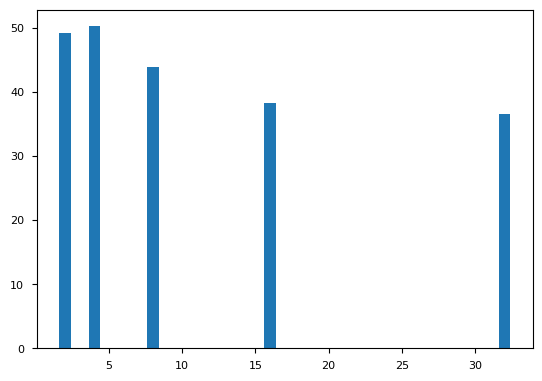

In [110]:
x0 = np.array([2, 4, 8, 16, 32])
y0 = np.array([results0[i][0][-1] for i in results0])*100

plt.bar(x0,y0)
plt.show()

# - Number of layers (Accuracy first increases then decreases)

In [94]:


experiment_configs = [
    {"name": "num_layers=2", "patch_size": 8, "num_layers": 2, "num_heads": 4},
    {"name": "num_layers=4", "patch_size": 8, "num_layers": 4, "num_heads": 4},
    {"name": "num_layers=8", "patch_size": 8, "num_layers": 8, "num_heads": 4},
    {"name": "num_layers=16", "patch_size": 8, "num_layers": 16, "num_heads": 4},
    {"name": "num_layers=32", "patch_size": 8, "num_layers": 32, "num_heads": 4},
    # {"name": "Patch=8", "patch_size": 4, "num_layers": 6, "num_heads": 12}
]

results = {}

for cfg in experiment_configs:
    print("=" * 50)
    print(f"Experiment: {cfg['name']}")
    model_exp = make_experiment_vit(patch_size=cfg['patch_size'],
                                    num_layers=cfg['num_layers'],
                                    num_heads=cfg['num_heads'])
    results[cfg["name"]] = train_experiment(model_exp, train_loader, test_loader, epochs=3)


Experiment: num_layers=2


Epoch [1/3] Test: 100%|██████████| 79/79 [00:01<00:00, 45.32it/s, acc=37.6]


Epoch 1 | Train Acc: 0.286 | Test Acc: 0.376


Epoch [2/3] Test: 100%|██████████| 79/79 [00:01<00:00, 46.26it/s, acc=42.5]


Epoch 2 | Train Acc: 0.392 | Test Acc: 0.425


Epoch [3/3] Test: 100%|██████████| 79/79 [00:01<00:00, 46.16it/s, acc=43.4]


Epoch 3 | Train Acc: 0.435 | Test Acc: 0.434
Experiment: num_layers=4


Epoch [1/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.33it/s, acc=39]  


Epoch 1 | Train Acc: 0.274 | Test Acc: 0.391


Epoch [2/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.23it/s, acc=43.8]


Epoch 2 | Train Acc: 0.391 | Test Acc: 0.438


Epoch [3/3] Test: 100%|██████████| 79/79 [00:01<00:00, 42.32it/s, acc=45.4]


Epoch 3 | Train Acc: 0.431 | Test Acc: 0.454
Experiment: num_layers=8


Epoch [1/3] Test: 100%|██████████| 79/79 [00:02<00:00, 38.80it/s, acc=33.1]


Epoch 1 | Train Acc: 0.241 | Test Acc: 0.331


Epoch [2/3] Test: 100%|██████████| 79/79 [00:02<00:00, 38.27it/s, acc=38.7]


Epoch 2 | Train Acc: 0.345 | Test Acc: 0.387


Epoch [3/3] Test: 100%|██████████| 79/79 [00:02<00:00, 39.25it/s, acc=45]  


Epoch 3 | Train Acc: 0.404 | Test Acc: 0.450
Experiment: num_layers=16


Epoch [1/3] Test: 100%|██████████| 79/79 [00:02<00:00, 28.72it/s, acc=10]  


Epoch 1 | Train Acc: 0.100 | Test Acc: 0.100


Epoch [2/3] Test: 100%|██████████| 79/79 [00:02<00:00, 28.33it/s, acc=10]  


Epoch 2 | Train Acc: 0.101 | Test Acc: 0.100


Epoch [3/3] Test: 100%|██████████| 79/79 [00:02<00:00, 28.92it/s, acc=10]  


Epoch 3 | Train Acc: 0.101 | Test Acc: 0.100
Experiment: num_layers=32


Epoch [1/3] Test: 100%|██████████| 79/79 [00:04<00:00, 17.92it/s, acc=10]  


Epoch 1 | Train Acc: 0.099 | Test Acc: 0.100


Epoch [2/3] Test: 100%|██████████| 79/79 [00:04<00:00, 17.94it/s, acc=10]  


Epoch 2 | Train Acc: 0.099 | Test Acc: 0.100


Epoch [3/3] Test: 100%|██████████| 79/79 [00:04<00:00, 17.78it/s, acc=10]  

Epoch 3 | Train Acc: 0.101 | Test Acc: 0.100


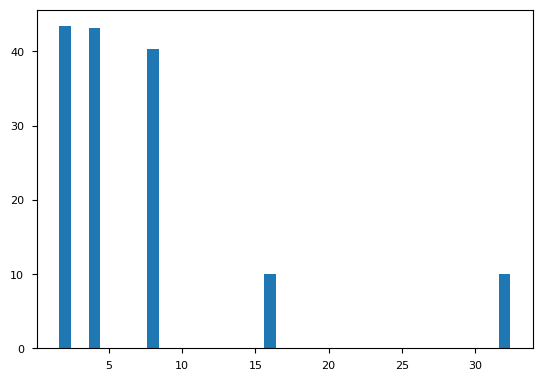

In [103]:
x = np.array([2, 4, 8, 16, 32])
y = np.array([results[i][0][-1] for i in results])*100

plt.bar(x,y)
plt.show()

# - Number of heads (Accuracy increases as the number of heads increases up to a point)

In [106]:
experiment_configs = [
    {"name": "num_heads=2", "patch_size": 8, "num_layers": 4, "num_heads": 2},
    {"name": "num_heads=4", "patch_size": 8, "num_layers": 4, "num_heads": 4},
    {"name": "num_heads=8", "patch_size": 8, "num_layers": 4, "num_heads": 8},
    {"name": "num_heads=16", "patch_size": 8, "num_layers": 4, "num_heads": 16},
    {"name": "num_heads=32", "patch_size": 8, "num_layers": 4, "num_heads": 32},
    # {"name": "Patch=8", "patch_size": 4, "num_layers": 6, "num_heads": 12}
]

results3 = {}

for cfg in experiment_configs:
    print("=" * 50)
    print(f"Experiment: {cfg['name']}")
    model_exp = make_experiment_vit(patch_size=cfg['patch_size'],
                                    num_layers=cfg['num_layers'],
                                    num_heads=cfg['num_heads'])
    results3[cfg["name"]] = train_experiment(model_exp, train_loader, test_loader, epochs=3)


Experiment: num_heads=2


Epoch [1/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.95it/s, acc=32.6]


Epoch 1 | Train Acc: 0.285 | Test Acc: 0.326


Epoch [2/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.97it/s, acc=42.8]


Epoch 2 | Train Acc: 0.373 | Test Acc: 0.428


Epoch [3/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.74it/s, acc=45.4]


Epoch 3 | Train Acc: 0.417 | Test Acc: 0.454
Experiment: num_heads=4


Epoch [1/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.90it/s, acc=37.6]


Epoch 1 | Train Acc: 0.285 | Test Acc: 0.376


Epoch [2/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.79it/s, acc=45.1]


Epoch 2 | Train Acc: 0.400 | Test Acc: 0.451


Epoch [3/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.92it/s, acc=45.8]


Epoch 3 | Train Acc: 0.440 | Test Acc: 0.458
Experiment: num_heads=8


Epoch [1/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.88it/s, acc=38.6]


Epoch 1 | Train Acc: 0.287 | Test Acc: 0.386


Epoch [2/3] Test: 100%|██████████| 79/79 [00:01<00:00, 42.14it/s, acc=43.7]


Epoch 2 | Train Acc: 0.402 | Test Acc: 0.437


Epoch [3/3] Test: 100%|██████████| 79/79 [00:01<00:00, 42.69it/s, acc=48.2]


Epoch 3 | Train Acc: 0.447 | Test Acc: 0.482
Experiment: num_heads=16


Epoch [1/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.27it/s, acc=39.4]


Epoch 1 | Train Acc: 0.289 | Test Acc: 0.394


Epoch [2/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.06it/s, acc=47]  


Epoch 2 | Train Acc: 0.418 | Test Acc: 0.470


Epoch [3/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.68it/s, acc=49.6]


Epoch 3 | Train Acc: 0.466 | Test Acc: 0.496
Experiment: num_heads=32


Epoch [1/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.13it/s, acc=38.7]


Epoch 1 | Train Acc: 0.289 | Test Acc: 0.387


Epoch [2/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.28it/s, acc=46.1]


Epoch 2 | Train Acc: 0.420 | Test Acc: 0.461


Epoch [3/3] Test: 100%|██████████| 79/79 [00:01<00:00, 41.32it/s, acc=49.3]

Epoch 3 | Train Acc: 0.469 | Test Acc: 0.493


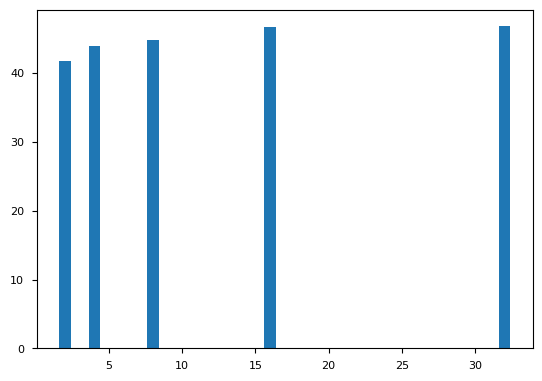

In [108]:
x3 = np.array([2, 4, 8, 16, 32])
y3 = np.array([results3[i][0][-1] for i in results3])*100

plt.bar(x3,y3)
plt.show()